In [1]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

In [2]:
episodes = 1000
eps_start = 0.9
eps_end = 0.01
eps_decay = 2000 # 클수록 느림
gamma = 0.8
lr = 0.0001
batch_size = 64

In [3]:
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256), #신경망은 카트 위치, 카트 속도, 막대기 각도, 막대기 속도까지 4가지 정보를 입력
            nn.ReLU(),
            nn.Linear(256, 2)  #출력은 왼쪽 or 오른쪽
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr)
        self.steps_done = 0
        self.memory = deque(maxlen=10000)
    
    def memorize(self, state, action, reward, next_state):
        self.memory.append((state, action, torch.FloatTensor([reward]), torch.FloatTensor([next_state])))
    
    def act(self, state):
        eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * self.steps_done / eps_decay)
        self.steps_done += 1
        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])
    
    def learn(self):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states = zip(*batch)
        
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)
        
        current_q = self.model(states).gather(1, actions)
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (gamma * max_next_q)
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [4]:
agent = DQNAgent()
env = gym.make('CartPole-v0')
score_history = []

Episode : 10 	 score : 12
Episode : 20 	 score : 13
Episode : 30 	 score : 19
Episode : 40 	 score : 17
Episode : 50 	 score : 11
Episode : 60 	 score : 11
Episode : 70 	 score : 21
Episode : 80 	 score : 14
Episode : 90 	 score : 12
Episode : 100 	 score : 8
Episode : 110 	 score : 13
Episode : 120 	 score : 10
Episode : 130 	 score : 10
Episode : 140 	 score : 17
Episode : 150 	 score : 47
Episode : 160 	 score : 30
Episode : 170 	 score : 56
Episode : 180 	 score : 91
Episode : 190 	 score : 170
Episode : 200 	 score : 177
Episode : 210 	 score : 144
Episode : 220 	 score : 164
Episode : 230 	 score : 200
Episode : 240 	 score : 172
Episode : 250 	 score : 200
Episode : 260 	 score : 200
Episode : 270 	 score : 200
Episode : 280 	 score : 200
Episode : 290 	 score : 182
Episode : 300 	 score : 200
Episode : 310 	 score : 200
Episode : 320 	 score : 200
Episode : 330 	 score : 200
Episode : 340 	 score : 200
Episode : 350 	 score : 200
Episode : 360 	 score : 200
Episode : 370 	 scor

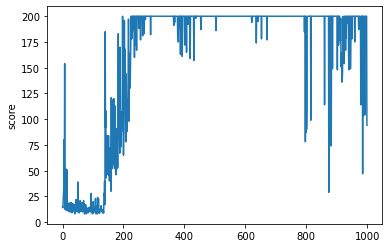

In [5]:
steps = 0
for e in range(1, episodes + 1):
    state = env.reset()
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action.item())
    
        if done:
            reward = -1
        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1
        
        if done:
            score_history.append(steps)
            if e % 10 == 0:
                print("Episode : {0} \t score : {1}".format(e, steps))
            break
    
plt.plot(score_history)
plt.ylabel('score')
plt.show()